In [1]:
import numpy as np
import math
from munkres import Munkres
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd

## Fonctions de base

In [2]:
def descriptor(V):
    """ Renvoi une liste de descripteurs d'un signal V """
    fourier = abs(np.fft.fft(V))
    freq = np.fft.fftfreq(len(V))
    fr_max = freq[np.argmax(fourier)]
    return np.array([np.mean(V), np.std(V), np.corrcoef(V), np.std(fourier),fr_max, fr_max/np.max(fourier)])

In [13]:
def nb_descriptors():
    a = np.zeros(100)
    d = descriptor(a)
    return len(d)

nb_descriptors()

/home/eloise/.local/lib/python2.7/site-packages/numpy/lib/function_base.py:3181: RuntimeWarning: invalid value encountered in true_divide
  return c / c
/home/eloise/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


6

In [3]:
def compute_cost(indexes, matrix):
    """ Calcule la distance du cantonnier à partir du flot et de la matrice des distances """
    total = 0
    for row, columns in indexes:
        total += matrix[row][columns]
    return total

# Chargement des données

In [26]:
def load_data(data_file):
    df = pd.read_csv(data_file)
    T, nb_sim = np.shape(df)
    nb_sim -= 1
    print("Time horizon:", T)
    print("Number of simulations:", nb_sim)
    return nb_sim, T, df

#nb_sim, T, df = load_data("out_O2_taub.csv")
nb_sim1, T1, df1 = load_data("out_O2_rand500.csv")
nb_sim2, T2, df2 = load_data("out_O2_taub500.csv")

('Time horizon:', 36)
('Number of simulations:', 500)
('Time horizon:', 36)
('Number of simulations:', 500)


In [27]:
def plot_data(df):
    variables = [col for col in list(df.columns) if 'V' in col]
    
    plt.figure()
    for col in variables:
        plt.plot(df[col])
    plt.title('O2 evolution on {} simulations'.format(len(variables)))
    plt.ylabel('O2')
    plt.xlabel('time')
    plt.show()

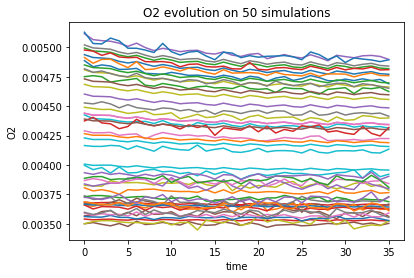

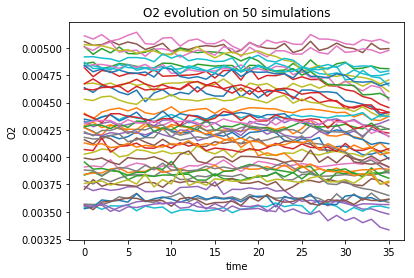

In [28]:
var = ['V' + str(i) for i in range(51, 101)]
plot_data(df1[var])
plot_data(df2[var])

# Distance de Wasserstein

In [29]:
def distance_EMD(desc1, desc2, dist_function):
    """ Trouve le flot de distance minimale """
    D = np.zeros((len(desc1), len(desc2)))
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            D[i, j] = np.linalg.norm(desc1[i] - desc2[j])

    m = Munkres()
    Dist_matrix = D.copy()
    indexes = m.compute(D)

    total_cost = compute_cost(indexes, Dist_matrix)
    return indexes, total_cost/len(desc1)

#  Test de Kolmogorov-Smirnov

In [33]:
nb_desc = nb_descriptors()

desc1 = np.zeros((nb_sim1, nb_desc))
desc2 = np.zeros((nb_sim2, nb_desc))

var1 = [col for col in list(df1.columns) if 'V' in col]
var2 = [col for col in list(df2.columns) if 'V' in col]
    
for (idx,col) in enumerate(var1):
    desc1[idx,:] = descriptor(df1[col])
    
for (idx,col) in enumerate(var2):
    desc2[idx,:] = descriptor(df2[col])
    

pvalues = np.zeros((nb_desc))    
for i in range(0,nb_desc):
    [x,pvalues[i]] = stats.ks_2samp(desc1[:,i],desc2[:,i])
    
meanp = np.mean(pvalues)
print pvalues, meanp

/home/eloise/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


[9.09001039e-02 1.62194074e-37 1.00000000e+00 1.06291772e-01
 1.00000000e+00 1.00000000e+00] 0.5328653126134552


In [35]:
def descriptor_matrix(df, nb_desc):
    
    desc = np.zeros((nb_sim1, nb_desc))
    var = [col for col in list(df.columns) if 'V' in col]
    
    for (idx,col) in enumerate(var):
        desc[idx,:] = descriptor(df[col])
    
    return desc


def meanks(V1,V2):

    nb_desc = nb_descriptors()
    desc1 = descriptor_matrix(V1,nb_desc)
    desc2 = descriptor_matrix(V2,nb_desc)

    pvalues = np.zeros((nb_desc))    
    for i in range(0,nb_desc):
        [x,pvalues[i]] = stats.ks_2samp(desc1[:,i],desc2[:,i])

    return pvalues

In [37]:
pvalues = meanks(df1,df2)
meanp = np.mean(pvalues)

print pvalues, meanp

/home/eloise/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


[9.09001039e-02 1.62194074e-37 1.00000000e+00 1.06291772e-01
 1.00000000e+00 1.00000000e+00] 0.5328653126134552
